<ipython-input-15-77176211a724>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Eduacation'] = X['Eduacation'].map(education_mapping)


         Feature        VIF
0            Age   4.324462
1     Eduacation   2.128929
2  Earnings_1974  14.253125
3  Earnings_1975  13.422672
Coefficients: [-98.83386892  43.18284354   0.33123648   0.44603221]
Intercept: 7189.479971794685
Mean Squared Error: 47524761.56211872
Mean Absolute Error: 5086.541743916435
R-squared: 0.48300855775758744


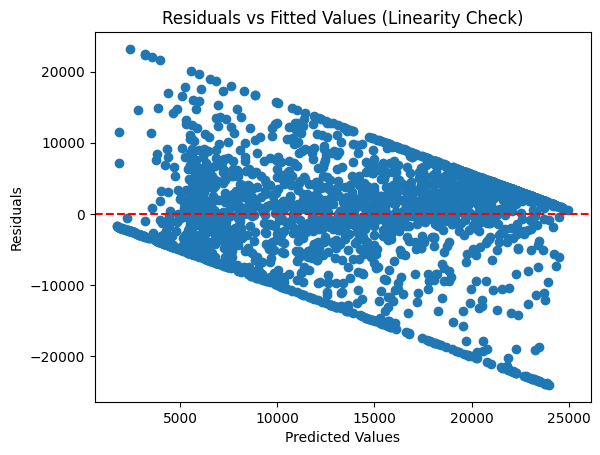

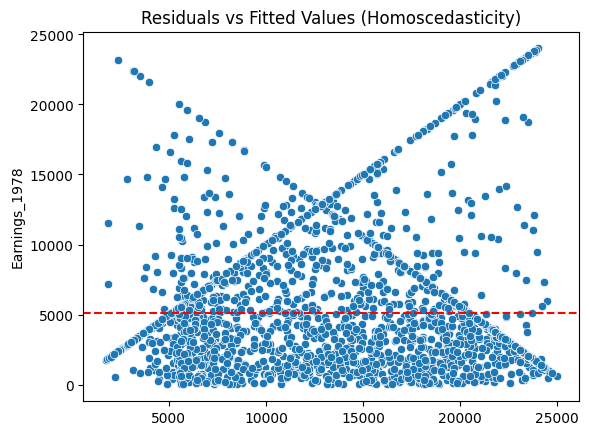

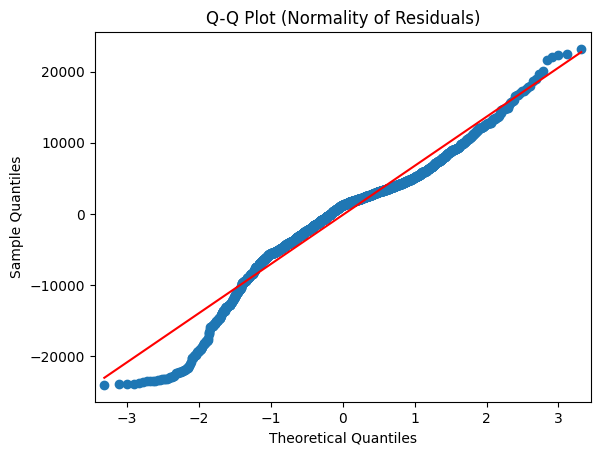

Durbin-Watson Statistic: 1.9769684088818242


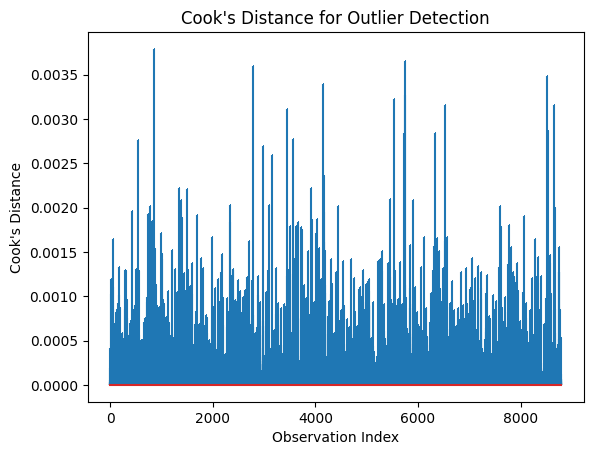

   Age          Eduacation  Earnings_1974  Earnings_1975  \
0   45  LessThanHighSchool      21516.670       25243.55   
2   38          HighSchool      23039.020       25130.76   
3   48  LessThanHighSchool      24994.370       25243.55   
4   18  LessThanHighSchool       1669.295       10727.61   
5   22  LessThanHighSchool      16365.760       18449.27   

   Predicted_Earnings_1978  
0             21128.498283  
2             22317.468096  
3             21983.937792  
4             10748.261302  
5             18665.040253  


In [ ]:
# Importing Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Load the Data
df = pd.read_csv('Dataset1.csv')  # Replace with your dataset file name

# ... (rest of your data cleaning and preprocessing)

# Define Target Variable and Features
# Update: Include all columns or select specific columns generated by get_dummies
X = df[['Age', 'Eduacation', 'Earnings_1974', 'Earnings_1975'] + [col for col in df.columns if col.startswith(('Race_', 'Hisp_', 'MaritalStatus_'))]]

# Convert 'Eduacation' column to numeric representation using mapping:
education_mapping = {
    'LessThanHighSchool': 0,
    'HighSchool': 1,
    'JuniorCollege': 2,
    'Bachelor': 3,
    'Graduate': 4  # Add more levels as needed
}
X['Eduacation'] = X['Eduacation'].map(education_mapping)

# Ensure all columns in X are numeric and handle missing/infinite values
X = X.astype(float) # This line is added to convert all columns in X to float type.

# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute or remove NaN values
# Option 1: Impute with the mean
# X.fillna(X.mean(), inplace=True)

# Option 2: Remove rows with NaN values
X.dropna(inplace=True)
df = df[df.index.isin(X.index)] # Update df to match the rows in X after dropping NaNs

y = df['Earnings_1978']

# ... (rest of your code)
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check Multicollinearity (VIF)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)


# Fit Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Coefficients and Intercept
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# Predictions
y_pred = model.predict(X_test)

# Evaluate Model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

# Assumptions Checking

# Residuals
residuals = y_test - y_pred

# 1. Linearity
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Linearity Check)')
plt.show()

# 2. Homoscedasticity
sns.scatterplot(x=y_pred, y=np.abs(residuals))
plt.axhline(np.mean(np.abs(residuals)), color='red', linestyle='--')
plt.title("Residuals vs Fitted Values (Homoscedasticity)")
plt.show()

# 3. Normality of Residuals
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot (Normality of Residuals)")
plt.show()

# 4. Autocorrelation (Durbin-Watson Test)
dw = sm.stats.durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {dw}")

# Outliers Detection (Cook's Distance)
influence = sm.OLS(y_train, sm.add_constant(X_train)).fit().get_influence()
(c, _) = influence.cooks_distance
# Remove the 'use_line_collection' argument
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.title("Cook's Distance for Outlier Detection")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.show()

# Final Prediction for 1978 Earnings
final_predictions = model.predict(X)
df['Predicted_Earnings_1978'] = final_predictions

print(df[['Age', 'Eduacation', 'Earnings_1974', 'Earnings_1975', 'Predicted_Earnings_1978']].head())

# Save Results to a File
df.to_csv('predicted_labour_earnings_1978.csv', index=False)
